<h1>C4 Solution</h1>

<h3>Install and import</h3>

In [2]:
%%capture
import sys
!{sys.executable} -m pip install smdebug torch torchvision tqdm

In [3]:
import os
import boto3
import sagemaker
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics

<h3>Get the data and copy it to S3</h3>

In [ ]:
%%capture
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [3]:
%%capture
!aws s3 cp dogImages s3://udacitymlproject4/ --recursive

<h3>Set up parameters, estimator, and tuner</h3>

In [4]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

role = sagemaker.get_execution_role()

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [5]:
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='pytorch_dog_hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    py_version='py3'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=1,  # you once have one ml.g4dn.xlarge instance available
    objective_type=objective_type
)

<h3>Fit the tuner</h3>

In [6]:
os.environ['SM_CHANNEL_TRAINING']='s3://udacitymlproject4/'
os.environ['SM_MODEL_DIR']='s3://udacitymlproject4/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://udacitymlproject4/output/'
tuner.fit({"training": "s3://udacitymlproject4/"})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


<h3>Describe the tuning results</h3>


In [8]:
exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-230417-1019')

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

,batch_size,learning_rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
2,"""256""",0.015983,pytorch-training-230417-1019-001-1a225b0d,Completed,988.0,2023-04-17 10:20:38+00:00,2023-04-17 10:41:20+00:00,1242.0
0,"""128""",0.006621,pytorch-training-230417-1019-003-2e416da5,Completed,220.0,2023-04-17 10:46:45+00:00,2023-04-17 11:05:51+00:00,1146.0
1,"""512""",0.009014,pytorch-training-230417-1019-002-ba9c7841,Failed,NaN,2023-04-17 10:44:03+00:00,2023-04-17 10:46:31+00:00,148.0


## Imp: If kernel dies, how to continue from a completed training job

In [4]:
BetterTrainingJobName='dog-pytorch-2023-04-17-11-29-15-852'
my_estimator = sagemaker.estimator.Estimator.attach(BetterTrainingJobName)
my_estimator.hyperparameters()
best_estimator=my_estimator


2023-04-17 11:44:55 Starting - Preparing the instances for training
2023-04-17 11:44:55 Downloading - Downloading input data
2023-04-17 11:44:55 Training - Training image download completed. Training in progress.
2023-04-17 11:44:55 Uploading - Uploading generated training model
2023-04-17 11:44:55 Completed - Training job completed


<h3>Prepare to perform Training on Best Estimator</h3>

In [5]:
best_estimator=tuner.best_estimator()

NameError: name 'tuner' is not defined

In [6]:
best_estimator.hyperparameters()

{'batch_size': '128',
 'learning_rate': '"0.00662117582001255"',
 'sagemaker_container_log_level': '20',
 'sagemaker_job_name': '"dog-pytorch-2023-04-17-11-29-15-852"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-075730753027/dog-pytorch-2023-04-17-11-29-15-852/source/sourcedir.tar.gz"'}

In [12]:
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimator.hyperparameters()['learning_rate']}
hyperparameters

{'batch_size': 128, 'learning_rate': '0.00662117582001255'}

In [13]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [14]:
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

<h2>Creating an Estimator</h2>

In [17]:
#adjust this cell to accomplish multi-instance training
estimator = PyTorch(
    entry_point='hpo.py',
    base_job_name='dog-pytorch',
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [20]:
estimator.fit({"training": "s3://udacitymlproject4/"}, wait=False)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: dog-pytorch-2023-04-17-11-26-09-752


<h2>Creating an Estimator - Multi-Instance Training,</h2>

In [21]:
###in this cell, create and fit an estimator using multi-instance training
multi_instance_estimator = PyTorch(
    entry_point='hpo.py',
    base_job_name='dog-pytorch',
    role=role,
    instance_count=3,
    instance_type='ml.m5.2xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [22]:
multi_instance_estimator.fit({"training": "s3://udacitymlproject4/"}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: dog-pytorch-2023-04-17-11-29-15-852


2023-04-17 11:29:16 Starting - Starting the training job...
2023-04-17 11:29:41 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2023-04-17 11:30:41 Downloading - Downloading input data......
2023-04-17 11:31:41 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-04-17 11:31:43,589 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-04-17 11:31:43,593 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2023-04-17 11:31:43,604 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-04-17 11:31:43,606 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-04-17 11:31:43,779 sagemaker-

<h2>Deployment</h2>

In [7]:
model_location=best_estimator.model_data


In [8]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor


In [9]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [11]:
role = sagemaker.get_execution_role()

In [12]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='infernce2.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [13]:
predictor = pytorch_model.deploy(initial_instance_count=3, instance_type='ml.m5.2xlarge')


----!

In [29]:
import requests
#request_dict={ "url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg" }
request_dict={ "url": "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

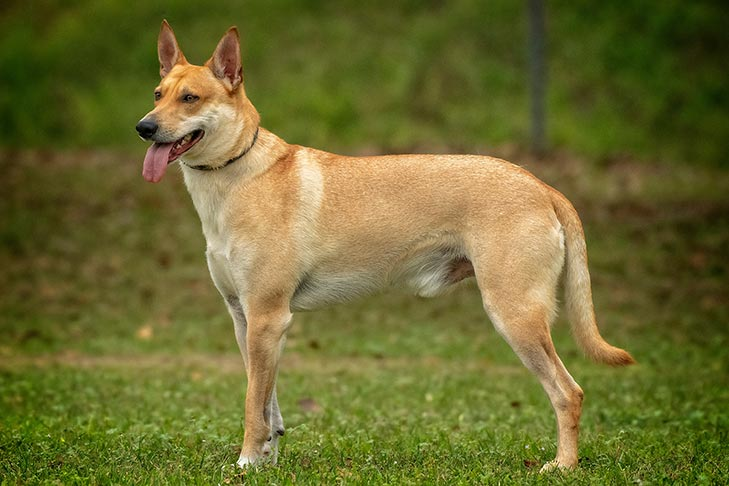

In [30]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [31]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [32]:
import json
response2=predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})

In [33]:
type(response2[0][0])

float

In [34]:
response2[0]

[-7.380711555480957,
 -2.193012237548828,
 -1.728313684463501,
 1.0639053583145142,
 -5.764138698577881,
 -2.0543229579925537,
 -0.11336326599121094,
 -2.4461753368377686,
 -6.334575176239014,
 -0.059182897210121155,
 2.2222537994384766,
 -5.8622870445251465,
 -1.5888727903366089,
 3.4883241653442383,
 -6.742661952972412,
 -3.5655410289764404,
 -7.756707191467285,
 0.51579350233078,
 -2.596541166305542,
 0.624711275100708,
 -5.459048748016357,
 -1.4667305946350098,
 -8.425110816955566,
 -2.6374971866607666,
 -2.1247544288635254,
 -7.312129974365234,
 -4.063277244567871,
 -4.881282329559326,
 -9.135810852050781,
 -1.979447841644287,
 -3.402405261993408,
 -1.6739455461502075,
 -6.237095355987549,
 -1.9730955362319946,
 -7.204339027404785,
 -4.231589317321777,
 -3.3783626556396484,
 -2.825732946395874,
 0.9898806214332581,
 -3.4377262592315674,
 -4.417032241821289,
 -3.827392339706421,
 4.0011773109436035,
 -4.73421573638916,
 -0.1472233235836029,
 -7.304174423217773,
 -2.9438207149505615

In [35]:
import torch
import numpy as np
np.argmax(response, 1)

array([42])